In [1]:
!pip install ../Course_Tools/introdl

Processing c:\users\bagge\my drive\python_projects\ds776_develop_project\ds776\lessons\course_tools\introdl
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for introdl: filename=introdl-1.0-py3-none-any.whl size=46416 sha256=1722573a4f8643b41e618b5d3591b8cd578bb53ca110ed0093bf8e965c223086
  Stored in directory: C:\Users\bagge\AppData\Local\Temp\pip-ephem-wheel-cache-rm4wrpts\wheels\f5\d5\0f\11f1d5af64d00defb23fa33cf51b2946a0899888d73571e687
Successfully built introdl
  Attempting uninstall: introdl
    Found existing installation: introdl 1.0
    Uninstalling introdl-1.0:
      Successfully uninstalled introdl-1.0


In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
import torch
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler

from introdl.utils import get_device, wrap_print_text, config_paths_keys
from introdl.nlp import llm_configure, llm_generate, llm_list_models

print = wrap_print_text(print)

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

#paths = config_paths_keys(env_path='../Course_Tools/mac.env')
paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

# for just this lesson
LESSON_DATA_PATH = Path('./data').resolve()
data_path = LESSON_DATA_PATH / 'IT_tickets_classify.csv'

MODELS_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models
DATA_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data
TORCH_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads


## Text Classification


The field of text classification has been completely revolutionized since the invention of transformer models in 2017.  I asked ChatGPT for a brief history of state-of-the-art approaches.  After a bit of refinement here's what it had to say:

(if nothing else, read the headers and short descriptions ...)

### **Chronology of State-of-the-Art Approaches for Text Classification**  

This timeline provides an overview of major advancements in text classification, from traditional machine learning models using Bag-of-Words and TF-IDF to modern transformer-based models like BERT and GPT.

---

### **Pre-2010s: Traditional ML with TF-IDF and Bag-of-Words**  
Before deep learning, text classification relied on statistical and machine learning approaches that used **Bag-of-Words (BoW)** and **TF-IDF** features. Popular classifiers included **Naïve Bayes, Support Vector Machines (SVMs), and Decision Trees**, which performed well despite ignoring word order and meaning.

- **1990s–Early 2000s**: Classical machine learning algorithms were widely used with simple BoW and TF-IDF feature representations.
- **2003–2010**: Topic modeling techniques like **Latent Semantic Analysis (LSA)** and **Latent Dirichlet Allocation (LDA)** emerged, helping with dimensionality reduction and improving classification performance.

---

### **2010s: Word Embeddings and Deep Learning**  
Fixed word embeddings, such as **Word2Vec** and **GloVe**, improved text representations by capturing word relationships in continuous vector spaces. Deep learning architectures like **CNNs and RNNs (LSTMs, GRUs)** further enhanced classification by learning sequential patterns in text.

- **2013**: **Word2Vec (Mikolov et al.)** introduced dense word embeddings, significantly improving text classification features over TF-IDF.
- **2014**: **GloVe (Pennington et al.)** refined word embeddings using word co-occurrence statistics, outperforming Word2Vec in some tasks.
- **2014–2015**: **CNNs for text classification** (e.g., Kim 2014) and **Recurrent Neural Networks (RNNs) with LSTMs/GRUs** became widely adopted.
- **2015–2016**: **Attention mechanisms** (Bahdanau et al. 2015) improved RNNs by helping models focus on important words in a sentence.

---

### **Late 2010s: Pretrained Contextual Embeddings and Transfer Learning**  
Contextual word embeddings and transformer architectures introduced a paradigm shift in text classification by learning rich, bidirectional word representations.

- **2018**: **ELMo (Peters et al.)** introduced deep contextualized embeddings, capturing word meaning based on sentence context.
- **2018**: **BERT (Devlin et al.)** revolutionized NLP by leveraging masked language modeling and bidirectional transformers to significantly improve classification accuracy.
- **2019**: **DistilBERT (Sanh et al.)** was introduced as a smaller, faster version of BERT, making transformer-based fine-tuning more efficient.

---

### **2020s: Transformer Fine-Tuning and Large Language Models (LLMs)**  
Modern NLP models rely on large-scale transformers trained on massive datasets. These models often perform well with minimal fine-tuning and even excel in zero-shot or few-shot classification tasks.

- **2020**: **RoBERTa (Liu et al.)**, **ALBERT (Lan et al.)**, and **XLNet (Yang et al.)** improved transformer-based models for classification by optimizing training techniques and model architecture.
- **2021–2023**: **GPT-3 and ChatGPT** demonstrated strong zero-shot and few-shot classification abilities, reducing the need for supervised fine-tuning.
- **2024–Present**: **LLMs like GPT-4 and fine-tuned versions (e.g., GPT-4-turbo, Mistral, Llama)** dominate text classification, often replacing traditional ML and deep learning approaches.

---


## Classifying Technical Support Requests Example

In this notebook we'll demonstrate and compare three approaches for text classification.  As an example we'll classify technical support help requests into categories using a dataset downloaded from Kaggle.  Briefly, here are the three approaches we'll use:

1.  A "pre-2010s" technique where statstical analysis of the help requests is used to create vectors containing information about the frequencies of words in the documents.  Those vectors are used as feature vectors for a typical machine learning classifier like logistic regression.

2. A "2020s" technique where we fine-tune a pre-trained transformer classification model.

3. An LLM-based approach with zero-shot and few-shot prompts.

Our goal is to build an automated classifier that can be used to send support tickets to appropriate technical support staff.


### Load and Visualize Data

This dataset is a public domain dataset found on Kaggle called []"IT Service Ticket Classification Dataset"](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset).  We'll included the csv file in the data subdirectory along in the same directory as this notebook.  

The data includes 47,837 help requests and their classifications into 8 categories: 'Hardware', 'HR Support', 'Access', 'Miscellaneous', 'Storage', 'Purchase', 'Internal Project', 'Administrative rights'.

Let's load the data and explore it a bit.



In [2]:
data_path = Path('./data/IT_tickets_classify.csv').resolve() 
df = pd.read_csv(data_path)

print(f'This dataset has {df.shape[0]} IT tickets')

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

This dataset has 47837 IT tickets


Print the first few rows to get a sense of the data:

In [3]:
df.head(10)

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous
5,mail please dear looks blacklisted receiving m...,Miscellaneous
6,prod servers tunneling prod tunneling va la tu...,Hardware
7,access request dear modules report report cost...,HR Support
8,reset passwords for our client and passwords c...,Access
9,direct reports missing time please action repo...,HR Support


Let's look at the distribution of the labels to geta sense of whether the dataset is balanced.  We can also see how long the help reequsts are.

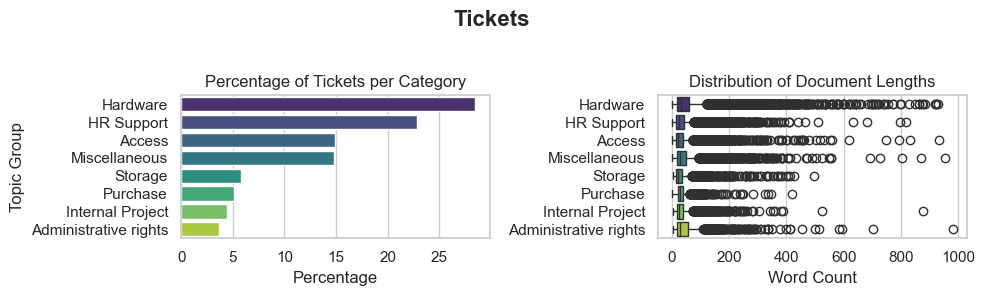

In [4]:
# Calculate percentages per category
category_counts = df["Topic_group"].value_counts(normalize=True) * 100
category_percentages = category_counts.reset_index()
category_percentages.columns = ["Topic_group", "Percentage"]

# Calculate lengths of documents as word count
df["Document_Length"] = df["Document"].apply(lambda x: len(x.split()))

# Get the order of categories from the barplot data
category_order = category_percentages["Topic_group"]

# Create a consistent color palette
palette = sns.color_palette("viridis", len(category_order))
color_mapping = dict(zip(category_order, palette))

# Create the side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10,3))

# Barplot: Percentage per category
sns.barplot(
    data=category_percentages,
    x="Percentage",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[0]
)
axes[0].set_title("Percentage of Tickets per Category")
axes[0].set_xlabel("Percentage")
axes[0].set_ylabel("Topic Group")

# Boxplot: Distribution of document lengths
sns.boxplot(
    data=df,
    x="Document_Length",
    y="Topic_group",
    palette=color_mapping,
    hue="Topic_group",
    order=category_order,
    ax=axes[1]
)
axes[1].set_title("Distribution of Document Lengths")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("")

# Set the suptitle
fig.suptitle("Tickets", fontsize=16, weight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The distribution of labels shows that the dataset is moderately imbalanced with a ration of the smallest class frequency to the largest class frequency of about 4:28 or 1:7.  We'll look at the classification report to see if imbalance is creating an issue.  

Nearly all of the help requests are about 100 words or less with only outliers having greater lengths.

### Prepare the data

Split the data and build mappings from text labels to integer labels and vice versa.

In [5]:
test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = list(set(train_labels_str + test_labels_str))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]



---

## Approach 1: Create Statistical Embedding Vectors and Apply Standard ML

We're going to create TF-IDF vectors to represent each help request.  Then we'll use those TF-IDF vectors to train and test a logistic regression classifier.

### What Are TF-IDF Vectors?

TF-IDF (Term Frequency-Inverse Document Frequency) vectors are a statistical representation of text data that capture the importance of terms within a document relative to a collection of documents (the corpus). This method assigns a weight to each term based on its frequency in a specific document (term frequency, TF) and how common or rare it is across all documents in the corpus (inverse document frequency, IDF). The result is a sparse, numerical vector for each document, where each dimension corresponds to a unique term in the vocabulary. TF-IDF is widely used in text mining, natural language processing, and machine learning as a feature extraction technique for tasks like classification, clustering, and information retrieval. However, as the size of the vocabulary grows, the dimensionality of the TF-IDF vectors increases, potentially leading to computational inefficiencies and the curse of dimensionality.

---

### Tricks for Limiting Dimensionality

To address the high dimensionality of TF-IDF vectors, several preprocessing techniques can be applied to reduce the vocabulary size while retaining the most meaningful terms. **Stemming** is one such method, where words are reduced to their root forms (e.g., "running" → "run"), grouping related words into a single term and thereby reducing the vocabulary size. Similarly, **lemmatization** refines this process by considering the context and part of speech to produce base forms. Removing **stopwords** like "the," "is," and "and" eliminates common, less informative terms that appear frequently across documents. Setting thresholds for **minimum and maximum document frequency** (e.g., `min_df` and `max_df`) ensures that terms appearing in very few documents or nearly all documents are excluded from the vocabulary. Additionally, limiting the vocabulary size directly with `max_features` retains only the top terms with the highest importance scores. Finally, incorporating **n-grams** (e.g., bigrams and trigrams) helps capture multi-word phrases, adding context while keeping the range limited to prevent explosive growth in dimensionality. Combining these techniques creates a more compact, computationally efficient representation of text data while preserving its semantic richness.

### Building the vectors

We'll use the TfidfVectorizer from sci-kit learn.  Here we're telling it to ignore common English stop words - words like "the", "end", "to" that carry little meaningful information on their own.  We're also telling the vectorizer to consider one-, two-, or three- word sequences (ngrams) as entries in the vocabulary so that "ball" and "big red ball" could be distinct.


In [6]:

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English stopwords
    min_df=2,  # Remove rare terms (appear in fewer than 2 documents)
    max_df=0.85,  # Remove overly common terms (appear in more than 85% of documents)
    max_features=1000,  # Limit vocabulary size to top 1000 terms
    ngram_range=(1, 3)  # Include unigrams, bigrams, and trigrams
)

# Fit the vectorizer and transform the input texts
train_features_tfidf = tfidf_vectorizer.fit_transform(train_texts_str)
test_features_tfidf = tfidf_vectorizer.transform(test_texts_str)

We can see below that the vectors for train_features are stored in a sparse array with 38,269 rows and 1000 columns.  Those 38,269 rows represent all help requests in teh training data.  The vectors have dimension 1000 because that's the size of the vocabulary we allowed.

In [7]:
train_features_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 873248 stored elements and shape (38269, 1000)>

Now we fit a logistic regression model using scikit-learn and make predictions for the test data.  We also produce a confusion matrix and a classification report.

Classification Report:
                       precision    recall  f1-score   support

               Access       0.92      0.87      0.89      1455
Administrative rights       0.84      0.70      0.76       342
           HR Support       0.84      0.83      0.84      2107
             Hardware       0.79      0.87      0.83      2760
     Internal Project       0.89      0.79      0.84       451
        Miscellaneous       0.80      0.82      0.81      1400
             Purchase       0.96      0.88      0.92       497
              Storage       0.92      0.85      0.89       556

             accuracy                           0.84      9568
            macro avg       0.87      0.82      0.85      9568
         weighted avg       0.85      0.84      0.84      9568



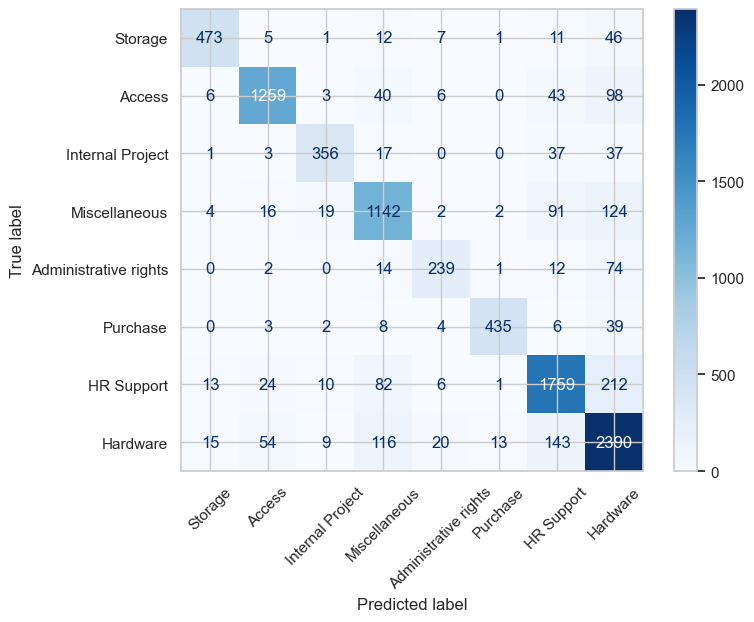

In [8]:
# Initialize and fit the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_features_tfidf, train_ids)

# Make predictions on the test set
test_predictions_id = model.predict(test_features_tfidf)

# Convert integer labels to string labels for the test set and predictions
test_predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, test_predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, test_predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": test_predictions_str
})

Overall, the model does well with 84% overall accuracy.  The smallest class, "Administrative Rights" is underpredicted.  The precision for that class is 84% suggesting the model is usually right when it predicts "Administrative Rights", but the recall is only 70% meaning that the model misses many instances of this class (it underpredicts).

We can try to correct for the imbalance in the date to see if how that changes the overall results.  A simple way to do that is to tell the logistic regression model to use balanced class weights to put more weight on the minority classes.

Classification Report:
                       precision    recall  f1-score   support

               Access       0.90      0.88      0.89      1455
Administrative rights       0.58      0.90      0.71       342
           HR Support       0.86      0.80      0.83      2107
             Hardware       0.86      0.75      0.80      2760
     Internal Project       0.76      0.93      0.84       451
        Miscellaneous       0.76      0.85      0.80      1400
             Purchase       0.88      0.91      0.90       497
              Storage       0.83      0.92      0.88       556

             accuracy                           0.83      9568
            macro avg       0.81      0.87      0.83      9568
         weighted avg       0.84      0.83      0.83      9568



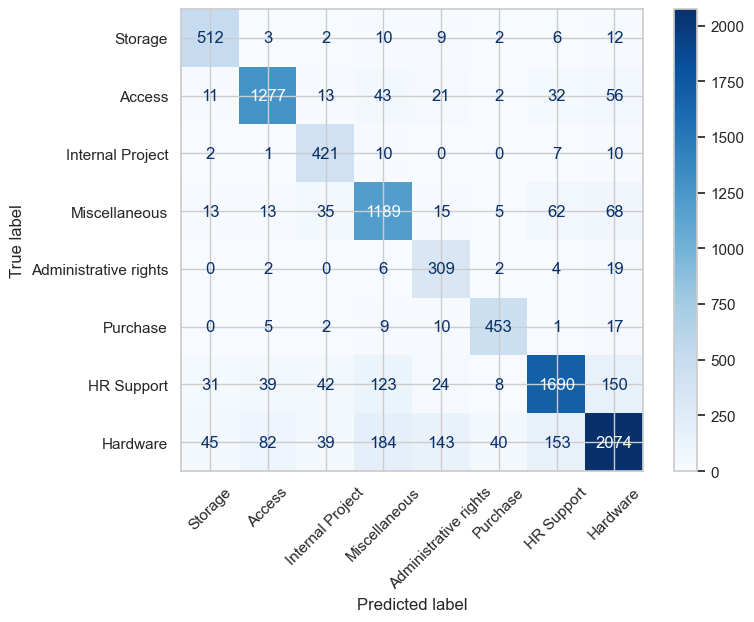

In [9]:
# Initialize and fit the logistic regression model
model = LogisticRegression(class_weight = 'balanced', max_iter=1000, random_state=42)
model.fit(train_features_tfidf, train_ids)

# Make predictions on the test set
test_predictions_id = model.predict(test_features_tfidf)

# Convert integer labels to string labels for the test set and predictions
test_predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, test_predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, test_predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

# Create and return a DataFrame with test labels and predictions
results_df = pd.DataFrame({
    "Test Labels": test_labels_str,
    "Predictions": test_predictions_str
})

Now the overall accuracy is 83%.  In correcting for the imbalance in teh data, the model is now overpredicting the minority "Administrative Rights" class.  You could choose one of those two models depending on which error is more tolerable, you could look for another way to address the data imbalance, or you could look for another modeling approach as we'll do in the next section.

## Approach 2: Transformer-based Text Classification Models



In this section we'll mimic what the textbook did, but using our IT service requests dataset to see how it compares to other approaches.

### Using Distilbert to Extract Features for Logistic Regression

In this approach we use a Distilbert model thas has been pre-trained on the mask-filling task to extract a feature vector for each help request.  The feature extraction in this approach is much slower than the previous approach since it involves a forward call of the model.  A GPU helps, but the computation needs to be done in batches unless your GPU has a lot of vRAM.  

The cell below for loading and splitting he data is the same as the in the first section but is here for convenience.  

In [7]:
data_path = Path('./data/IT_tickets_classify.csv').resolve() 
df = pd.read_csv(data_path)

# downsample for testing, set to 1.0 for no downsampling
downsample_ratio = 1.0
if downsample_ratio < 1.0:
    df = df.sample( int(downsample_ratio*df.shape[0]) )
    print(f'Downsampled dataset has {df.shape[0]} IT tickets')

test_size=0.2
random_state=42

"""Split data into train and test sets of strings, and map labels to integer ids."""
train_texts_str, test_texts_str, train_labels_str, test_labels_str = train_test_split(
    df["Document"].tolist(), df["Topic_group"].tolist(), test_size=test_size, random_state=random_state
)

# Map labels to integer ids
unique_labels = list(set(train_labels_str + test_labels_str))
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Convert labels to integer ids as lists
train_ids = [label_to_id[label] for label in train_labels_str]
test_ids = [label_to_id[label] for label in test_labels_str]


Now we tokenize the datasets, which means converting the words or subwords to integers according to their position in a vocabulary definied in the tokenizer.

In [11]:
# Load Pre-trained Model and Tokenizer
model_checkpoint = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Set a padding token (use an existing one or define a new one)
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))  # Adjust model embedding size

# Check for GPU
device = get_device()
print(f"Using device: {device}")

def tokenize_dataset(tokenizer, texts, labels):
    """Tokenize the dataset."""
    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding=True), batched=True)
    return tokenized_dataset

# Tokenize datasets
train_tokenized = tokenize_dataset(tokenizer, train_texts_str, train_ids)
test_tokenized = tokenize_dataset(tokenizer, test_texts_str, test_ids)



Using device: cuda


Map:   0%|          | 0/38269 [00:00<?, ? examples/s]

Map:   0%|          | 0/9568 [00:00<?, ? examples/s]

The cell below took about 5 minutes to run on a decent NVIDIA gaming GPU.

In [12]:
# Load the pre-trained DistilBERT model
model = AutoModel.from_pretrained(model_checkpoint)
model.to(device)

# Extract features for train and test sets in batches using tokenized datasets
def extract_features_from_tokenized(tokenized_dataset, model, device, batch_size=100):
    """Extract features from tokenized dataset using DistilBERT in batches."""
    features = []
    for i in range(0, len(tokenized_dataset), batch_size):
        batch = tokenized_dataset[i:i + batch_size]
        inputs = {key: torch.tensor(value).to(device) for key, value in batch.items() if key in ["input_ids", "attention_mask"]}
        with torch.no_grad():
            outputs = model(**inputs)
        batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        features.append(batch_features)
    return np.vstack(features)

# Extract features for train and test sets
train_features_bert = extract_features_from_tokenized(train_tokenized, model, device)
test_features_bert = extract_features_from_tokenized(test_tokenized, model, device)

To fit a logistic regression model using these feature vectors, they need to be rescaled or the logistic regression model training may have trouble converging.  You can read more about [feature scaling here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py).

Classification Report:
                       precision    recall  f1-score   support

               Access       0.79      0.79      0.79      1455
Administrative rights       0.67      0.61      0.64       342
           HR Support       0.75      0.76      0.76      2107
             Hardware       0.75      0.76      0.75      2760
     Internal Project       0.77      0.71      0.74       451
        Miscellaneous       0.68      0.69      0.69      1400
             Purchase       0.88      0.86      0.87       497
              Storage       0.78      0.79      0.79       556

             accuracy                           0.75      9568
            macro avg       0.76      0.75      0.75      9568
         weighted avg       0.75      0.75      0.75      9568



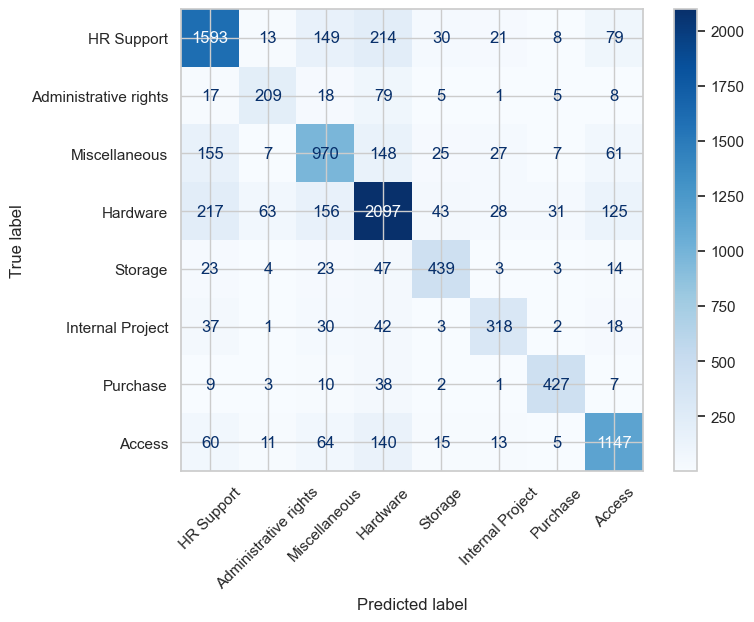

In [15]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training features and transform both train and test features
train_features_bert = scaler.fit_transform(train_features_bert)
test_features_bert = scaler.transform(test_features_bert)

# Train logistic regression model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(train_features_bert, train_ids)

# Make predictions on the test set
test_predictions_id = log_reg_model.predict(test_features_bert)

# Convert integer labels to string labels for the test set and predictions
predictions_str = [id_to_label[label] for label in test_predictions_id]

# Compute classification metrics
print("Classification Report:")
print(classification_report(test_labels_str, predictions_str))

# Compute and display the confusion matrix
cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_label.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()

This model performed worse than the model using TF-IDF vectors.  For this dataset the TF-IDF approach does rather well, but we'll see in the next section that even a small transformer model like Distilbert will perform better.  

### Fine-tuning Dilbert

Now, instead of freezing the backbone and using it to extract features, we're going to add a newly initialized classification head and fine-tune the whole model for two epochs.  This allows the feature vectors to adapt to the dataset a little and for the classification head to leverage this information to improve the predictions.  

We have quite a few options set for training here.  We'll discuss some of them in a video:

In [18]:
# Took about 18 minutes on Nvidia 4070 Super Ti

batch_size = 32 # reduce if memory issues

models_and_logs_dir = MODELS_PATH / 'L08_fine_tune_distilbert'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(label_to_id)).to(device)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir=models_and_logs_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=False,
    bf16=True,
    logging_dir=models_and_logs_dir / "logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    save_total_limit=1,
    logging_steps=int(len(train_tokenized) / (batch_size * 10)),
    report_to="none",
    disable_tqdm=False,
    dataloader_pin_memory=True,
    log_level="info",
    log_level_replica="info"
    )

def compute_metrics(pred):
    """Compute evaluation metrics."""
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"eval_accuracy": acc, "eval_f1": f1, "eval_precision": precision, "eval_recall": recall}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
output = trainer.train()

# Save the fine-tuned model
model.save_pretrained(models_and_logs_dir / "best_model")
tokenizer.save_pretrained(models_and_logs_dir / "best_model")


loading configuration file config.json from cache at C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads\hub\models--distilbert-base-uncased\snapshots\12040accade4e8a0f71eabdb258fecc2e7e948be\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.403600,0.406564,0.863085,0.863763,0.867495,0.863085
2,0.242300,0.352894,0.885870,0.885784,0.885947,0.885870


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 9568
  Batch size = 32
Saving model checkpoint to C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L08_fine_tune_distilbert\checkpoint-1196
Configuration saved in C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L08_fine_tune_distilbert\checkpoint-1196\config.json
Model weights saved in C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L08_fine_tune_distilbert\checkpoint-1196\model.safetensors
tokenizer config file saved in C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L08_fine_tune_distilbert\checkpoint-1196\tokenizer_config.json
Special tokens file saved in C:\Users\bagge\My Drive\Python_Pr

('C:\\Users\\bagge\\My Drive\\Python_Projects\\DS776_Develop_Project\\models\\L08_fine_tune_distilbert\\best_model\\tokenizer_config.json',
 'C:\\Users\\bagge\\My Drive\\Python_Projects\\DS776_Develop_Project\\models\\L08_fine_tune_distilbert\\best_model\\special_tokens_map.json',
 'C:\\Users\\bagge\\My Drive\\Python_Projects\\DS776_Develop_Project\\models\\L08_fine_tune_distilbert\\best_model\\vocab.txt',
 'C:\\Users\\bagge\\My Drive\\Python_Projects\\DS776_Develop_Project\\models\\L08_fine_tune_distilbert\\best_model\\added_tokens.json',
 'C:\\Users\\bagge\\My Drive\\Python_Projects\\DS776_Develop_Project\\models\\L08_fine_tune_distilbert\\best_model\\tokenizer.json')

Now we'll make predictions with our newly fine-tuned model and build a classification report.

In [19]:
predictions = trainer.predict(test_tokenized)

y_true_id = predictions.label_ids
y_pred_id = np.argmax(predictions.predictions, axis=1)

test_labels_str = [id_to_label[label] for label in y_true_id]
predictions_str = [id_to_label[label] for label in y_pred_id]

print("Classification Report:")
print(classification_report(y_true_id, y_pred_id, target_names=list(id_to_label.values())))

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 9568
  Batch size = 32


Classification Report:
                       precision    recall  f1-score   support

              Storage       0.90      0.93      0.91       556
               Access       0.91      0.94      0.92      1455
     Internal Project       0.90      0.88      0.89       451
        Miscellaneous       0.85      0.86      0.86      1400
Administrative rights       0.84      0.79      0.81       342
             Purchase       0.96      0.90      0.93       497
           HR Support       0.89      0.88      0.88      2107
             Hardware       0.88      0.88      0.88      2760

             accuracy                           0.89      9568
            macro avg       0.89      0.88      0.89      9568
         weighted avg       0.89      0.89      0.89      9568



We can see that the overall accuracy has improved to about 89%.  Moreover, the imbalanced data seems to be less of an issue since the precision and recall for the smallest and largest classes are more similar than they were before.  The model does seem to be underpredicting Administrative Rights a little, but is still improved over the previous models.  It may continue to improve by fine-tuning for another epoch or two.

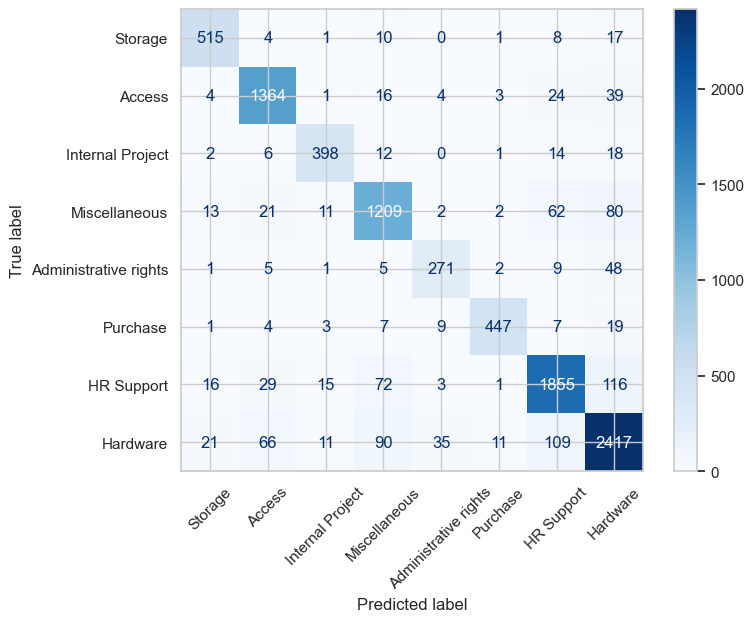

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels_str, predictions_str, labels=list(id_to_label.values()))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.xticks(rotation=45)
plt.show()


## Approach 3: Use an LLM and prompting for Classification

Here we'll demonstrate how to use an LLM with zero-shot prompting.  Zero-shot means we're not providing any classification examples in our prompt.  Instead, we specify the possible labels and additional instructions and let the an LLM try to sort it out!

In [3]:
available_models = llm_list_models(verbose=True);

Available models:
 llama-3p1-8B => HuggingFace: unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit
 mistral-7B => HuggingFace: unsloth/mistral-7b-instruct-v0.3-bnb-4bit
 llama-3p2-3B => HuggingFace: unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit
 gemini-flash-lite => needs GEMINI_API_KEY
 gemini-flash => needs GEMINI_API_KEY
 gpt-4o => needs OPENAI_API_KEY
 gpt-4o-mini => needs OPENAI_API_KEY
 o1-mini => needs OPENAI_API_KEY
 o3-mini => needs OPENAI_API_KEY


We experimented with the local models and found that llama-3p1-8B worked the best.  Here's how we load it:

In [4]:
LLM_MODEL = 'llama-3p1-8B'
LLM_MODEL = "mistral-7B"
llm_config = llm_configure(LLM_MODEL)

🚀 Loading model: unsloth/mistral-7b-instruct-v0.3-bnb-4bit (this may take a while)...
🟢 Model unsloth/mistral-7b-instruct-v0.3-bnb-4bit loaded successfully.



We've built a helper function for using our selected LLM as a classifier.  We'll talki about it a bit in our video and show how to use it via an example.

In [11]:
def llm_classifier( llm_config, 
                    texts, 
                    system_prompt,
                    prompt_template,
                    batch_size=1):
    """
    Classify text using a Large Language Model (LLM).

    Args:
        llm_config (ModelConfig): Configuration for the LLM.
        texts (list of str): List of text documents to classify.
        system_prompt (str): System prompt to guide the LLM.
        prompt_template (str): Template for user prompts to classify each text.

    Returns:
        list of str: Predicted labels for the input texts.
    """
    """Classify text using LLM."""
    user_prompts = [prompt_template.format(text=text) for text in texts]
    predicted_labels = llm_generate(llm_config, 
                                    user_prompts, 
                                    system_prompt=system_prompt,
                                    search_strategy='deterministic',
                                    batch_size=batch_size)

    return predicted_labels
    

It's a good idea to experiment with a small number of examples to refine your prompts.  It can be difficult to get an LLM to produce the exact output you want so you often need to be very directed in your prompts. 

In the next cell we try to classify the first 10 requests in the test set.

In [17]:

N = 10
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

predictions = llm_classifier( llm_config, texts, system_prompt, prompt_template, batch_size=10)

for i in range(N):
    print(f"Support Request: {texts[i]}\n")
    print(f"Predicted Label: {predictions[i]}, Actual Label: {labels[i]}")
    print("-----------------------------------------------\n")

Support Request: issue with server process sent tuesday issue with server
process hi could you please help with following issue getting once few minutes
discipline lead

Predicted Label: Storage, Actual Label: Hardware
-----------------------------------------------

Support Request: new purchase po wednesday february purchase po dear purchased
please log installation please take consideration mandatory receipts section
order receive item ordered kind regards administrator information

Predicted Label: Purchase, Actual Label: Purchase
-----------------------------------------------

Support Request: oracle pas urgent re we updated rights query hi can get some
assistance here looks like have full control for codes only one working for
cannot forecast need done by friday thanks programme portfolio officer mobile
phone

Predicted Label: Administrative Rights, Actual Label: Hardware
-----------------------------------------------

Support Request: new starter access thursday pm re starter 

Now let's apply the LLM to 1,000 examples to compile some statistics about its performance. (This took about 16 minutes with my gaming GPU, so you may want to reduce N if you want to explore this code.)

In [18]:

N = 1000
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

predictions = llm_classifier( llm_config, texts, system_prompt, prompt_template, batch_size=50)

Even with detailed prompt this LLM is predicting non-existent labels.  We can use a python set to see all the unique labels. (sets ignore duplicates)

In [24]:
set(predictions)

{'Accept',
 'Access',
 'Accounting (or possibly HR Support if it\'s about employee accounts or similar, but given "ledger" and "accountant", I would lean towards Accounting)',
 'Administration',
 'Administration Officer',
 'Administration Rights',
 'Administrative Rights',
 'Administrative rights',
 'Approval',
 'Approval (for both "Approve Requisition Task" and "Identity View Task Details")',
 'Approved',
 'Authentication',
 'Azure',
 'Azure (Hardware)',
 'Backup',
 'Battery Drain (Hardware)',
 'Buyer Role',
 'Cancel (This is a simplified version of your request. The actual prediction would require more context and nuance to accurately determine the correct label.)',
 'Certificate Expired',
 'Change Phone Extensions',
 'Compliance Officer',
 'Confidential Information (Internal Project)',
 "Connection Issue (or Miscellaneous if it's unclear whether this is specifically about a hardware or software connection)",
 'Connection Issues with Servers',
 'Connectivity Issue (Hardware)',
 'Cons

In [25]:
# Define the valid labels
valid_labels = {'HR Support', 'Storage', 'Administrative rights', 'Internal Project', 'Purchase', 'Miscellaneous', 'Hardware', 'Access'}

# Find the indices of invalid predictions
valid_indices = [i for i, prediction in enumerate(predictions) if prediction in valid_labels]

valid_predictions = [predictions[i] for i in valid_indices]
valid_labels = [labels[i] for i in valid_indices]

print("Classification Report:")
print(classification_report(valid_labels, valid_predictions, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.29      0.55      0.38       115
Administrative rights       0.00      0.00      0.00        21
           HR Support       0.66      0.18      0.29       180
        Miscellaneous       0.65      0.43      0.52       218
             Purchase       0.25      0.77      0.38        43
             Hardware       0.34      0.20      0.25        98
     Internal Project       0.67      0.82      0.74        45
              Storage       0.24      0.12      0.16        40

             accuracy                           0.37       760
            macro avg       0.39      0.38      0.34       760
         weighted avg       0.50      0.37      0.38       760



Even if we throw away the the examples for which the LLM produced labels that aren't valid we get terrible performance compared to our other approaches.

In [34]:
print("Classification Report:")
# Find three examples from each class in the train_texts_str
examples_per_class = 3
few_shot_examples = {}

for text, label in zip(train_texts_str, train_labels_str):
    if len(text.split()) <= 50:  # Only use examples shorter than 50 words
        if label not in few_shot_examples:
            few_shot_examples[label] = []
        if len(few_shot_examples[label]) < examples_per_class:
            few_shot_examples[label].append(text)
        if all(len(examples) == examples_per_class for examples in few_shot_examples.values()):
            break

# Construct the few-shot prompt
few_shot_prompt_template = "You are an expert IT support request classifier.\n\n"
for label, examples in few_shot_examples.items():
    for example in examples:
        few_shot_prompt_template += f"Support Request: {example}\nPredicted Label: {label}\n\n"

few_shot_prompt_template += "Using only the labels: HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.\nClassify the following support request using exactly one of the labels. Do not use any other labels. You must return only the label with nothing else. If you are unsure, choose Miscellaneous.\nSupport Request: {text}, Predicted Label:"

print(few_shot_prompt_template)

Classification Report:
You are an expert IT support request classifier.

Support Request: suspect message do not open block user tuesday november user
tuesday november dear find attached revert regards
Predicted Label: Access

Support Request: issues with issues with hello last week changed password have
issues with accepting password thank you click here find out more about
experience specialist en address blvd th floor district
Predicted Label: Access

Support Request: access to com on port from port hi please assign please allow
ports machine slave caps pilot these ports opened order fetch instead passwords
git caps pilot git thank engineer
Predicted Label: Access

Support Request: oracle error sent wednesday error hi please below error get
when entering for th th cannot really more with error can you please pass thank
you head
Predicted Label: HR Support

Support Request: new starter center friday pm assistants starter testing
discipline dear please informed candidate accepted job 

In [35]:

N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

predictions_few_shot = llm_classifier( llm_config, texts, system_prompt, few_shot_prompt_template, batch_size=50)

In [38]:
# Define the valid labels
valid_labels = {'HR Support', 'Storage', 'Administrative rights', 'Internal Project', 'Purchase', 'Miscellaneous', 'Hardware', 'Access'}

# Find the indices of invalid predictions
valid_indices = [i for i, prediction in enumerate(predictions_few_shot) if prediction in valid_labels]

valid_predictions = [predictions_few_shot[i] for i in valid_indices]
valid_labels = [labels[i] for i in valid_indices]

print("Classification Report:")
print(classification_report(valid_labels, valid_predictions, target_names=list(id_to_label.values())))

Classification Report:
                       precision    recall  f1-score   support

               Access       0.27      0.60      0.38        10
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.80      0.18      0.30        22
        Miscellaneous       0.89      0.30      0.44        27
             Purchase       0.33      0.89      0.48         9
             Hardware       0.19      0.38      0.25        13
     Internal Project       1.00      1.00      1.00         8
              Storage       0.00      0.00      0.00         3

             accuracy                           0.41        96
            macro avg       0.44      0.42      0.36        96
         weighted avg       0.60      0.41      0.39        96



c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [39]:
llm_config = llm_configure('gemini-flash-lite')

N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

prompt_template = """Using only the labels: 
HR Support, Storage, Administrative rights, Internal Project, Purchase, Miscellaneous, Hardware, Access.
Classify the following support request using exactly one of the labels.  
Do not use any other labels.
You must return only the label with nothing else.
If you are unsure, choose Miscellaneous.
Support Request: {text}, Predicted Label:"""

predictions = llm_classifier( llm_config, texts, system_prompt, prompt_template, batch_size=50)

In [43]:
predictions# Define the valid labels
valid_labels = {'HR Support', 'Storage', 'Administrative rights', 'Internal Project', 'Purchase', 'Miscellaneous', 'Hardware', 'Access'}

# Find the indices of invalid predictions
valid_indices = [i for i, prediction in enumerate(predictions) if prediction in valid_labels]

valid_predictions = [predictions[i] for i in valid_indices]
valid_labels = [labels[i] for i in valid_indices]

print(f"There were {len(valid_predictions)} valid predictions out of {len(predictions)} total predictions.")

print("Classification Report:")
print(classification_report(valid_labels, valid_predictions, target_names=list(id_to_label.values())))

There were 100 valid predictions out of 100 total predictions.
Classification Report:
                       precision    recall  f1-score   support

               Access       0.20      0.82      0.32        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.67      0.27      0.39        22
        Miscellaneous       0.83      0.34      0.49        29
             Purchase       0.67      0.67      0.67         9
             Hardware       0.20      0.15      0.17        13
     Internal Project       0.67      0.89      0.76         9
              Storage       0.00      0.00      0.00         3

             accuracy                           0.41       100
            macro avg       0.40      0.39      0.35       100
         weighted avg       0.56      0.41      0.41       100



c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bagge\miniforge-pypy3\envs\DS776_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [44]:
N = 100
texts = test_texts_str[0:N]
labels = test_labels_str[0:N]

system_prompt = """You are an expert IT support request classifier."""

predictions_few_shot = llm_classifier( llm_config, texts, system_prompt, few_shot_prompt_template, batch_size=50)

In [46]:
# Define the valid labels
valid_labels = {'HR Support', 'Storage', 'Administrative rights', 'Internal Project', 'Purchase', 'Miscellaneous', 'Hardware', 'Access'}

# Find the indices of invalid predictions
valid_indices = [i for i, prediction in enumerate(predictions_few_shot) if prediction in valid_labels]

valid_predictions = [predictions_few_shot[i] for i in valid_indices]
valid_labels = [labels[i] for i in valid_indices]

print(f"There were {len(valid_predictions)} valid predictions out of {len(predictions)} total predictions.")

print("Classification Report:")
print(classification_report(valid_labels, valid_predictions, target_names=list(id_to_label.values())))

There were 100 valid predictions out of 100 total predictions.
Classification Report:
                       precision    recall  f1-score   support

               Access       0.32      0.64      0.42        11
Administrative rights       0.00      0.00      0.00         4
           HR Support       0.83      0.68      0.75        22
        Miscellaneous       0.90      0.31      0.46        29
             Purchase       0.70      0.78      0.74         9
             Hardware       0.23      0.38      0.29        13
     Internal Project       0.82      1.00      0.90         9
              Storage       0.00      0.00      0.00         3

             accuracy                           0.52       100
            macro avg       0.47      0.47      0.44       100
         weighted avg       0.65      0.52      0.53       100

